# Look-elsewhere effect

When searching for an excess (peak) in some phase-space which has an unknown location, one has to correct the local significance for the fact that one would have reported random peaks produced by chance in the entire phase-space if these peaks were as large as the observed one. The result is called global significance. It is possible to compute the global significance with Monte-Carlo simulation, but this is expensive.

Gross and Vitells give a recipe for a surprisingly simple approximate calculation of global significance, which requires no Monte-Carlo simulation whatsoever. One merely has to scan over the phase-space and count the number of upcrossings of the local significance of a small threshold.

This notebook attempts to apply the results from these two papers to a simple toy example:

* E.Gross, O. Vitells, "Trial factors for the look elsewhere effect in high energy physics", Eur. Phys. J. C 70 (2010) 525
* O. Vitells and E. Gross, "Estimating the significance of a signal in a multi-dimensional search", Astropart. Phys. 35 (2011) 230, arXiv:1105.4355

We search for a resonance in a wide mass window. Let's assume that an experiment has found a peak in this window that does not correspond to a known particle. We now want to quantify the global significance of this peak. The model for the peak is a voigtian, which has two unknown parameters: the location of the peak, equal to the mass of the particle, and the width of the Cauchy distribution, related to the unknown life-time of the particle. The width of the Gaussian is assumed to be known, since it corresponds to the resolution of the experiment.

In [1]:
from numba_stats import truncexpon, voigt
from scipy.stats import chi2
import numpy as np
from iminuit import Minuit
from iminuit.cost import ExtendedBinnedNLL
from matplotlib import pyplot as plt
from scipy.optimize import NonlinearConstraint
from jacobi import propagate

## Technical obstacles and their solutions

In the calculation, we evaluate the chi2 distribution in its upper tail. Computing the p-value as `1 - chi2(...).cdf(z ** 2)` becomes inaccurate when `z` is large. Instead, we use the survival function implemented in `scipy.stats`, which calculates `1 - cdf` accurately. Likewise, we use `chi2(...).isf` to compute the inverse of the survival function.

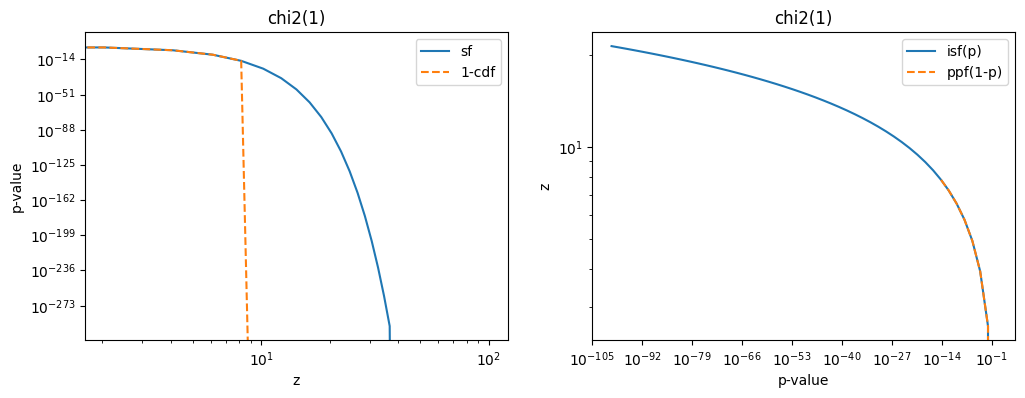

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.sca(ax[0])
z = np.linspace(0, 100)
plt.title("chi2(1)")
plt.plot(z, chi2(1).sf(z ** 2), label="sf")
plt.plot(z, 1 - chi2(1).cdf(z ** 2), label="1-cdf", ls="--")
plt.loglog()
plt.xlabel("z")
plt.ylabel("p-value")
plt.legend();

plt.sca(ax[1])
plt.title("chi2(1)")
p = np.geomspace(1, 1e-100)
plt.plot(p, chi2(1).isf(p) ** 0.5, label="isf(p)")
plt.plot(p, chi2(1).ppf(1 - p) ** 0.5, label="ppf(1-p)", ls="--")
plt.loglog()
plt.xlabel("p-value")
plt.ylabel("z")
plt.legend();

In [3]:
def pvalue_to_sigma(pvalue):
    return chi2(1).isf(pvalue) ** 0.5


def sigma_to_pvalue(sigma):
    return chi2(1).sf(sigma ** 2)

In the scan over the parameter space, we need to fit the model `µ s + b`, where `µ` is the signal amplitude, `s` is the signal shape, and `b` is the background density. To avoid issues with Wilks' theorem, we allow the fit find peaks with `µ < 0`. This opens the possibility that the sum of signal and background densities can locally become negative, which is forbidden, as densities cannot be negative, and would make the fit fail. To work around this, we perform a constrained minimization using iminuit but calling into scipy minimizers that support such constrains. 

## Construction of dataset

We construct the toy distribution. It is a background-only sample with a truncated exponential distribution.

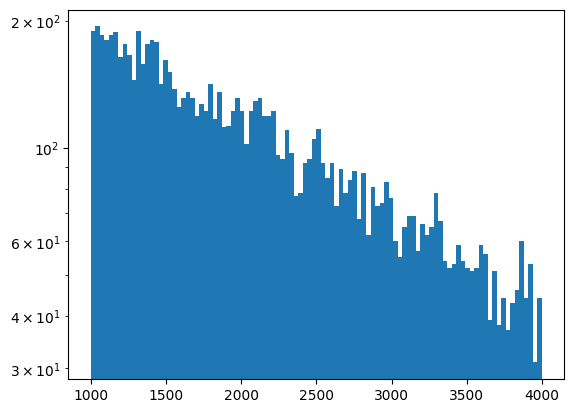

In [23]:
lambd_true = 2000
background_true = 10000

mass = truncexpon.rvs(1000, 4000, 0, lambd_true, background_true, 1)
plt.hist(mass, bins=100)
plt.semilogy();

## 1D case

We start with the 1D case. For this, we consider only the mass of the particle as unknown and fix the width of the Cauchy distribution to a constant. We scan over the unknown mass and compute local significance at each location. This requires fitting the signal + background model.

The local significance can be computed in two ways, but one turns out to be more accurate. The straight-forward way is via a likelihood ratio of the background only hypothesis in which the signal amplitude is zero, and the alternative hypothesis where the amplitude is non-zero. Asymptotically, the quantity $q$ is chi2 distributed according to Wilks' theorem:
$$
q = 2 \ln\frac{\mathcal{L}(\hat \mu, \theta, \hat \phi)}{\mathcal{L}(0, \theta, \hat \phi')}
$$
where $\mathcal{L}(\mu, \theta, \phi)$ is the likelihood for the problem, $\hat \mu$ is the best-fit of the signal amplitude, $\theta$ is a nuisance parameter fixed in the scan (here the mass of the signal peak), and $\hat \phi$ and $\hat \phi'$ represent the best fit values of the parameters of the background model for the two hypotheses, these take different values depending on whether $\mu$ is zero or not.

The second (and asymptotically equivalent) way is to compute the signal amplitude divided by the signal uncertainty estimated by the fit squared:
$$
q = \left(\frac{\hat \mu}{\hat \sigma(\mu)}\right)^2
$$
However, the numerical study here shows confirms that this way of calculating $q$ is less accurate and leads to deviations from the expected chi2 distribution. The reason is that the signal uncertainty is computed numerically from the second derivative of the log-likelihood, and is sometimes underestimated.

In [24]:
def model(xe, signal, mass, width, background, lambd):
    b = background * truncexpon.cdf(xe, 1000, 4000, 0, lambd)

    sigma_resolution = 50 # some fixed value

    # poor man's integration of voigt.pdf
    dx = np.diff(xe)
    ds = signal * voigt.pdf(xe[:-1] + 0.5 * dx, width, mass, sigma_resolution) * dx
    s = np.append(0, np.cumsum(ds))

    return s + b


def fit_background(mass):
    n, xe = np.histogram(mass, bins=100)
    c = ExtendedBinnedNLL(n, xe, model)        
    minuit = Minuit(c, signal=0, mass=0, width=100,
                    background=background_true, lambd=lambd_true)
    minuit.fixed["signal", "width", "mass"] = True
    minuit.limits["lambd", "background"] = (0, None)
    minuit.migrad()
    return minuit.fval, minuit


def fit(mass, m, chi2_background):
    n, xe = np.histogram(mass, bins=100)
    c = ExtendedBinnedNLL(n, xe, model)        
    minuit = Minuit(c, signal=0, mass=m, width=100,
                    background=background_true, lambd=lambd_true)
    minuit.fixed["width", "mass"] = True
    minuit.limits["lambd", "background"] = (0, None)
    minuit.migrad()
    # pdf must not be negative, if migrad fails, 
    # we ensure this with a constrained minimization,
    # see explaination above
    if not minuit.valid:
        minuit.reset()
        minuit.scipy(
            constraints=[NonlinearConstraint(lambda *args: np.diff(model(xe, *args)), 0, np.inf)]
        )
        if not minuit.valid:
            return np.nan, minuit

    # z = (minuit.values["signal"] / minuit.errors["signal"])
    z = np.copysign(max(chi2_background - minuit.fval, 0) ** 0.5, minuit.values["signal"])
    return z, minuit


def z_scan(mass, m_grid):
    chi2_background = fit_background(mass)[0]
    z = []
    for m in m_grid:
        z.append(fit(mass, m, chi2_background)[0])
    z = np.array(z)
    return z

m_grid = np.linspace(1200, 3800, 200)

z = z_scan(mass, m_grid)

Let's plot the most significant peak candidate.

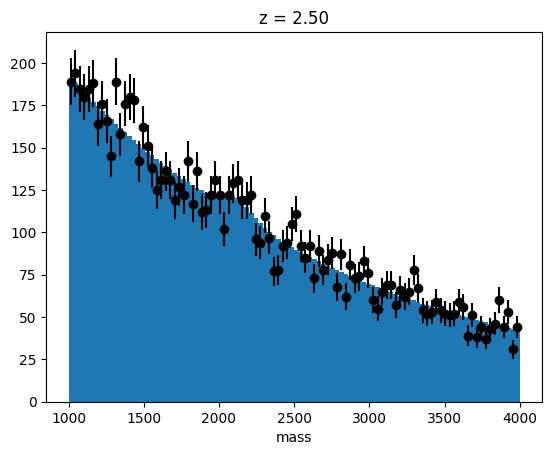

In [25]:
zmax, minuit = fit(mass, m_grid[np.argmax(z ** 2)], fit_background(mass)[0])
minuit.visualize()
plt.title(f"z = {zmax:.2f}")
plt.xlabel("mass");

It has a local significance of $2.5\sigma$. Next, we plot the local significance scanned over the mass range and corresponding p-value computed from a chi2 distribution.

From the second plot we can then read off the number of "upcrossings" when the local p-value becomes smaller than some predefined p-value threshold. Our local test statistic is sensitive to positive and negative deviations from the background, but we consider only positive excesses as evidence against the background only hypothesis. We compensate by dividing the p-value thresholds by two. This accounts for the fact that we get twice as many upcrossings above this threshold on average if we allow both positive and negative deviations to occur. This is particular effective because it allows us to count the "upcrossings" above $0\sigma$ at the threshold P=0.5, which are particularly frequent and thus have the smallest relative counting error.

Z_local = 2.50


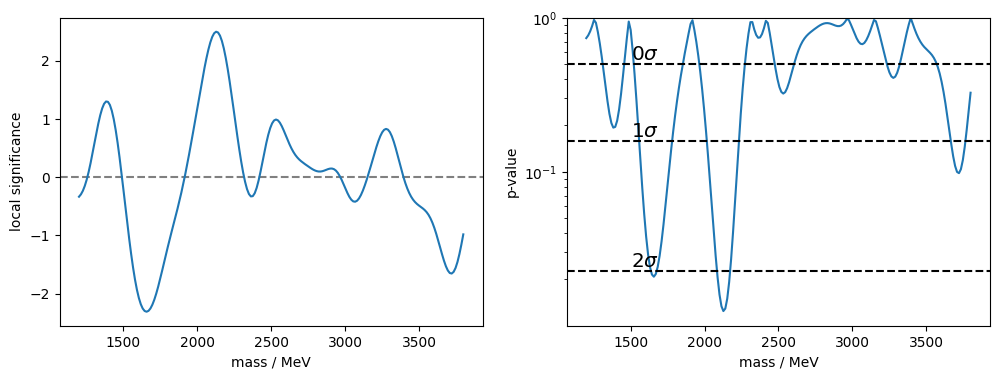

In [26]:
pvalue = sigma_to_pvalue(z)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.sca(ax[0])
plt.axhline(0, ls="--", color="0.5")
plt.xlabel("mass / MeV")
plt.ylabel("local significance")
plt.plot(m_grid, z)
plt.sca(ax[1])
plt.plot(m_grid, pvalue)
plt.semilogy()
plt.ylim(None, 1);
for sigma in range(0, 5):
    # for thresholds, we take half of p-value, see text
    p = 0.5 * sigma_to_pvalue(sigma)  
    if p > np.min(pvalue):
        plt.axhline(p, ls="--", color="k")
        plt.text(1500, p, f"${sigma}\sigma$", fontsize="x-large", va="bottom")
plt.ylabel("p-value")
plt.xlabel("mass / MeV");

z_local = z[np.argmax(z ** 2)]
print(f"Z_local = {z_local:.2f}")

The following functions compute the number of upcrossings, the global significance, and the global p-value from the local significance values.

In [28]:
def compute_number_of_upcrossings(z, z_threshold):
    pvalue = sigma_to_pvalue(z)
    # for thresholds, take half of p-value, see text
    p = 0.5 * sigma_to_pvalue(z_threshold)
    n = 0
    exceeded = False
    if pvalue[0] < p:
        exceeded = True
        n = 1
    for pi in pvalue:
        if exceeded and pi > p:
            exceeded = False
        elif not exceeded and pi <= p:
            exceeded = True
            n += 1
    return n


def compute_p_global(z_local, z_threshold, n_upcrossings):
    u_local = z_local ** 2
    u_threshold = z_threshold ** 2
    p_local = sigma_to_pvalue(z_local)
    return p_local + n_upcrossings * np.exp(0.5 * (u_threshold - u_local))

def compute_z_global(z_local, z_threshold, n_upcrossings):
    return pvalue_to_sigma(compute_p_global(z_local, z_threshold, n_upcrossings))

z_threshold = 0  # chosen threshold for upcrossings
n_upcrossings = compute_number_of_upcrossings(z, z_threshold)
print(f"upcrossings = {n_upcrossings}")

# propagate uncertainty of n_upcrossing, which is a Poisson distributed number
z_global, z_global_cov = propagate(
    lambda n: compute_z_global(z_local, z_threshold, n),
    n_upcrossings, n_upcrossings)

print(f"Z_global = {z_global:.2f} ± {z_global_cov ** 0.5:.2f}")

upcrossings = 6
Z_global = 1.09 ± 0.24


We computed a global significance of $(1.09 \pm 0.24) \sigma$ with the formula of Gross and Vitells. We now confirm this calculation with a toy simulation, in which we repeatedly simulate independent experiments, do the local scan and record the largest $q$ value found in this way. The global significance of observing a local significance of $q$ is then given by the number of experiments which yielded a value as large as this one or larger.

In [29]:
from joblib import delayed, Parallel
from pathlib import Path
import pickle
import gzip
from tqdm import tqdm

# we cache this calculation, it takes a while
cache_file = Path("q_samples.pkl.gz")

if cache_file.exists():
    with gzip.open(cache_file) as f:
        q = pickle.load(f)
else:
    q = []

    seeds = 10000

    @delayed
    def run(iseed):
        mass = truncexpon.rvs(1000, 4000, 0, lambd_true, background_true, iseed)
        z = z_scan(mass, m_grid)
        return np.max(z ** 2)

    q = Parallel(n_jobs=8)(run(iseed) for iseed in tqdm(range(seeds)))
    q = np.array(q)

    with gzip.open(cache_file, "w") as f:
        pickle.dump(q, f)

# check that all fits converged properly
np.mean(np.isnan(q))

0.0

Here is the distribution of the test statistic over many independent experiments.

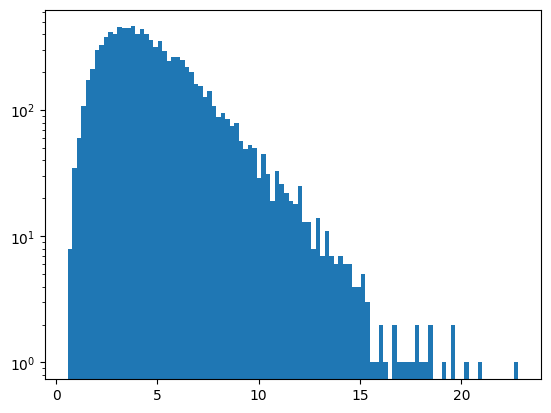

In [32]:
plt.hist(q, bins=100)
plt.semilogy();

The global significance of getting a local test statistic $q > 2.5^2$ in a scan is $1.2\sigma$, in agreement with the Gross & Vitells result.

In [33]:
pvalue_to_sigma(np.mean(q > 2.5 ** 2))

1.2104663380244483

Let's plot the experiment with the largest local $q$.

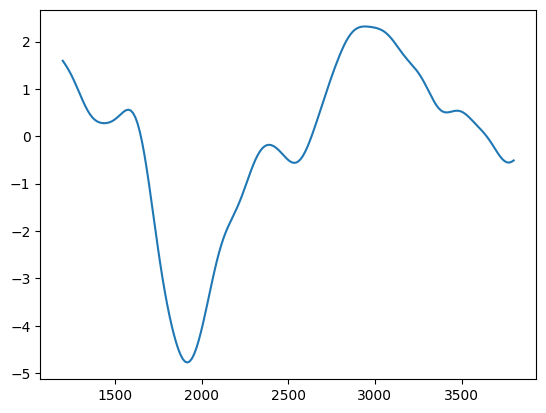

In [34]:
iseed = np.argmax(q)
mass = truncexpon.rvs(1000, 4000, 0, lambd_true, background_true, iseed)
m_grid = np.linspace(1200, 3800, 200)
z_m = []
for m in m_grid:
    z_m.append(fit(mass, m, fit_background(mass)[0]))
plt.plot(m_grid, [x[0] for x in z_m]);

The local excess is almost $5\sigma$. Here is the corresponding fit:

In [35]:
z_m[np.argmax([x[0]**2 for x in z_m])][1]

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 88.26 (χ²/ndof = 0.9)      │              Nfcn = 53               │
│ EDM = 5.49e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ signal     │   -290    │    60     │            │            │         │         │       │
│ 1 │ mass       │  1.919e3  │  0.019e3  │            │            │         │         │  yes  │
│ 2 │ width      │    100    │     1     │            │            │         │         │  yes  │
│ 3 │ background │  10.28e3  │  0.12e3   │            │            │    0    │         │       │
│ 4 │ lambd      │  1.95e3   │  0.05e3   │            │            │    0    │         │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬────────────────────────────────────────────────────────┐
│            │     signal       mass      width background      lambd │
├────────────┼────────────────────────────────────────────────────────┤
│     signal │   3.45e+03          0          0     -3.6e3      0.4e3 │
│       mass │          0          0          0          0          0 │
│      width │          0          0          0          0          0 │
│ background │     -3.6e3          0          0   1.37e+04     -0.3e3 │
│      lambd │      0.4e3          0          0     -0.3e3   2.14e+03 │
└────────────┴────────────────────────────────────────────────────────┘

Finally, we compare the Gross & Vitells formula with the simulation result for different local values of $q$, by plotting the global p-value from the simulation and the computed one from the formula. We use the bootstrap method to estimate the uncertainty of the simulated curve. Both results are in very good agreement above $q > 3^2$, so above a local significance of $3\sigma$. The beauty of the Gross & Vitells is that it works best if the local significance is large, which is exactly the case where the classic simulation strategy becomes infeasible.

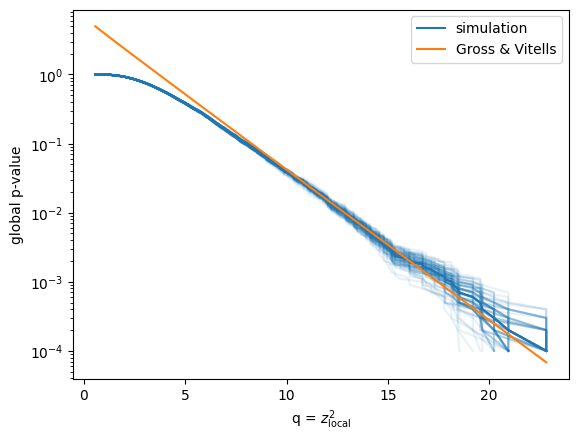

In [37]:
from resample.bootstrap import resample

p = 1 - np.arange(len(q)) / len(q)
q = np.sort(q)
plt.plot(q, p, label="simulation")

for qb in resample(q, size=100):
    qb = np.sort(qb)
    plt.plot(qb, p, color="C0", alpha=0.1)

p2 = compute_p_global(q ** 0.5, 0, 6)
plt.plot(q, p2, label="Gross & Vitells")
plt.semilogy()
plt.ylabel("global p-value")
plt.xlabel("q = $z_\\mathrm{local}^2$")
plt.legend();